### Tm calculations for polymerases with a DNA binding domain such as Phusion

The Phusion DNA polymerase is a processive version of the Pfu DNA polymerase. 
The enzyme was engineered with a DNA binding domain that tends to stabilize DNA, so
a higher annealing temperature is needed compared to other polymerases such as Taq.

Phusion was first marketed by Finnzyme, and they provided a Tm calculator applet that 
is no longer available. This applet was written in Java and I decompiled the code and
translated into python as the pydna.tm.tmbresluc. I unfortunately do not have the source 
code anymore, but I remember verifying that results were identical.

The Finnzyme calculator (and the pydna.tm.tmbresluc function) give a Tm that is quite high.
Phusion is now marketed by Thermofisher Scientific (TFS) and NEB and each provide their 
own Tm calculator:

[Thermofisher Tm](https://www.thermofisher.com/pt/en/home/brands/thermo-scientific/molecular-biology/molecular-biology-learning-center/molecular-biology-resource-library/thermo-scientific-web-tools/tm-calculator.html)

[NEB Tm](https://tmcalculator.neb.com)

These calculators give different values for the same primers and the same settings which are also different from
pydna.tm.tmbresluc and presumably the Finnzyme calculator.

For example, This primer is used as an example for the NEB Tm calculator:
    
    Tm
           Primer                         TFS    NEB    pydna
    P1fwd  AGCGGATAACAATTTCACACAGGA       65.7   62     64.3
    P1rev  GTAAAACGACGGCCAGT              60.2   57     55.1
    pBeta  AGCGGATAACAATTTCAC             55.9   52     51.6
    P3fwd  AGCGGATAAGGGCAATTTCAC          64.1   61     62.9
    P3rev  GTAAAACGACGGCCA                56.4   53     52.4

While Tm values are quite different, Suggested Annealing temperature (Ta) values for primer pairs 
are quite close. It appears that TFS picks the lowest of the two Tm values as Ta, while the NEB 
picks the lowest and adds 3C.

    Ta
    
    Primer pair                           TFS    NEB                 
    P1fwd + P1rev                         60.2   61
    P3fwd + P3rev                         56.4   57
    
Primer concentration was set to 500 nM and Phusion HF buffer was selected for the NEB celculator when applicable.
The raw data for the analysis above can be found in the two pdfs below:


[TFS Calculator result](Tm-Calculator_Thermo-Fisher-Scientific-PT.pdf)


[NEB Calculator result](NEB-Tm-Calculator.pdf)

In [9]:
from Bio.SeqUtils import MeltingTemp as mt

Biopython offers a [wide range of Tm formulas](https://biopython.org/DIST/docs/api/Bio.SeqUtils.MeltingTemp-module.html) and I will try to recreate the results of the TFS and NEB calculators using Biopython.

Unfortunatley, the descriptions provided by the companies is not enough to positively know how the 
calculations were done. For this reason I will loop through the most important settings provided by Biopython
to see if there is a match or at least a close match.

The primer concentrations were set to 500 nM and the Mg2+ to 1.5 mM as provided by the HF buffer ([description](MAN0013369_Phusion_HF_Buffer_Pack_UG.pdf)). 


There are seven different salt correction formulas 

       1. 16.6 x log[Na+]
          (Schildkraut & Lifson (1965), Biopolymers 3: 195-208)
       2. 16.6 x log([Na+]/(1.0 + 0.7*[Na+]))
          (Wetmur (1991), Crit Rev Biochem Mol Biol 126: 227-259)
       3. 12.5 x log(Na+]
          (SantaLucia et al. (1996), Biochemistry 35: 3555-3562
       4. 11.7 x log[Na+]
          (SantaLucia (1998), Proc Natl Acad Sci USA 95: 1460-1465
       5. Correction for deltaS: 0.368 x (N-1) x ln[Na+]
          (SantaLucia (1998), Proc Natl Acad Sci USA 95: 1460-1465)
       6. (4.29(%GC)-3.95)x1e-5 x ln[Na+] + 9.40e-6 x ln[Na+]^2
          (Owczarzy et al. (2004), Biochemistry 43: 3537-3554)
       7. Complex formula with decision tree and 7 empirical constants.
          Mg2+ is corrected for dNTPs binding (if present)
          (Owczarzy et al. (2008), Biochemistry 47: 5336-5353)


and four different tables with nearest neighbor thermodynamic data.

        - DNA_NN1: values from Breslauer et al. (1986)
        - DNA_NN2: values from Sugimoto et al. (1996)
        - DNA_NN3: values from Allawi & SantaLucia (1997) (default)
        - DNA_NN4: values from SantaLucia & Hicks (2004)

The dnac1 and 2 were set to 500 nM and Mg to 1.5 mM

The primer sequence is the P1fwd (see above).

In [10]:
from itertools import cycle

tables = cycle(['DNA_NN1', 'DNA_NN2', 'DNA_NN3', 'DNA_NN4'])

tms=[]
for saltcorr in [1,2,3,4,5,6,7]:
    print("saltcorrection", saltcorr)
    for nn_table in [mt.DNA_NN1,mt.DNA_NN2,mt.DNA_NN3,mt.DNA_NN4]:
        print( next(tables),   mt.Tm_NN( "AGCGGATAACAATTTCACACAGGA", # P1fwd
                               nn_table=nn_table,
                               Na=50,
                               Tris=75.0,
                               Mg=1.5, 
                               dnac1=500, 
                               dnac2=500, 
                               dNTPs=0.8, 
                               saltcorr=saltcorr))
    print()

saltcorrection 1
DNA_NN1 73.47550291410457
DNA_NN2 66.3161816707943
DNA_NN3 62.12795214651103
DNA_NN4 63.94506682293299

saltcorrection 2
DNA_NN1 72.58464965941893
DNA_NN2 65.42532841610866
DNA_NN3 61.23709889182539
DNA_NN4 63.054213568247356

saltcorrection 3
DNA_NN1 76.45241066662001
DNA_NN2 69.29308942330974
DNA_NN3 65.10485989902648
DNA_NN4 66.92197457544844

saltcorrection 4
DNA_NN1 77.03327071589132
DNA_NN2 69.87394947258105
DNA_NN3 65.68571994829779
DNA_NN4 67.50283462471975

saltcorrection 5
DNA_NN1 75.67602180131865
DNA_NN2 69.57693752740619
DNA_NN3 65.16353763529838
DNA_NN4 66.82918312259733

saltcorrection 6
DNA_NN1 77.67293356675424
DNA_NN2 70.82077552782476
DNA_NN3 66.80945823888635
DNA_NN4 68.55006949275128

saltcorrection 7
DNA_NN1 74.71273444065656
DNA_NN2 67.97461333236214
DNA_NN3 64.02902340553459
DNA_NN4 65.74120743229503



The third value above is 62.12795214651103 (saltcorrection 1 & DNA_NN3) is the closest to 62 which is the value for this primer by NEB Tm.
In the cell below, this setting is tested for all the previously listed primers. 

In [11]:
primers = """\
P1fwd	 AGCGGATAACAATTTCACACAGGA	
P1rev	 GTAAAACGACGGCCAGT	
pBeta	 AGCGGATAACAATTTCAC	
P3fwd	 AGCGGATAAGGGCAATTTCAC	
P3rev	 GTAAAACGACGGCCA"""

for name, primer in [s.split() for s in primers.splitlines()]:
    tm = mt.Tm_NN( primer,
                   nn_table=mt.DNA_NN3,
                   Na=50,
                   Tris=75.0,
                   Mg=1.5, 
                   dnac1=500, 
                   dnac2=500, 
                   dNTPs=0.8, 
                   saltcorr=1)
    print(name, f"{tm:.0f}")

P1fwd 62
P1rev 57
pBeta 52
P3fwd 61
P3rev 53


The output is identical to the one given by NEB. Saltcorrection = 1 corresponds to the one by Schildkraut & Lifson that [NEB says that they use](NEB_help.pdf) on their help page.
The Ta algorithm shoud then be described by the function below.

In [12]:
def Tm_NEB(primer):
    tm = mt.Tm_NN( primer,
               nn_table=mt.DNA_NN3,
               Na=50,
               Tris=75.0,
               Mg=1.5, 
               dnac1=500, 
               dnac2=500, 
               dNTPs=0.8, 
               saltcorr=1)
    return tm

In [39]:
def Ta_NEB(fp,rp):
    tms = []
    for primer in [fp,rp]:
        tms.append(Tm_NEB(primer))
    tm = min(tms) + 3.0
    return tm if tm<72 else 72

round(Ta_NEB("AGCGGATAACAATTTCACACAGGA","GTAAAACGACGGCCAGT")) # P1fwd + P1rev

60

The TFS calculator value for P1fwd AGCGGATAACAATTTCACACAGGA (65.7) corresponds best to the value for saltcorrection 7 & DNA_NN4 = 65.74120743229503 but also for saltcorrection 4 & DNA_NN3= 65.68571994829779. The first case gives:

In [14]:
primers = """\
P1fwd	 AGCGGATAACAATTTCACACAGGA	
P1rev	 GTAAAACGACGGCCAGT	
pBeta	 AGCGGATAACAATTTCAC	
P3fwd	 AGCGGATAAGGGCAATTTCAC	
P3rev	 GTAAAACGACGGCCA"""

for name, primer in [s.split() for s in primers.splitlines()]:
    tm = mt.Tm_NN( primer,
                   nn_table=mt.DNA_NN4,
                   Na=50,
                   Tris=75.0,
                   Mg=1.5,
                   dnac1=500, 
                   dnac2=500, 
                   dNTPs=0.8, 
                   saltcorr=7)
    print(name, f"{tm:.1f}")

P1fwd 65.7
P1rev 61.6
pBeta 55.5
P3fwd 65.5
P3rev 58.0


The second case gives:

In [15]:
primers = """\
P1fwd	 AGCGGATAACAATTTCACACAGGA	
P1rev	 GTAAAACGACGGCCAGT	
pBeta	 AGCGGATAACAATTTCAC	
P3fwd	 AGCGGATAAGGGCAATTTCAC	
P3rev	 GTAAAACGACGGCCA"""

for name, primer in [s.split() for s in primers.splitlines()]:
    tm = mt.Tm_NN( primer,
                   nn_table=mt.DNA_NN3,
                   Na=50,
                   Tris=75.0,
                   Mg=1.5,
                   dnac1=500, 
                   dnac2=500, 
                   dNTPs=0.8, 
                   saltcorr=4)
    print(name, f"{tm:.1f}")

P1fwd 65.7
P1rev 60.1
pBeta 55.5
P3fwd 64.1
P3rev 56.2


The second case above seems to be a better match. Saltcorrection 4 is the one described by SantaLucia (1998). ThermoFisher makes no reference to this paper afaik.
The code below generate a number of random primers for both calculators in order to test a wider selection of primers.

In [16]:
# import random
# def randomDNA(size=20, gc=0.5):
#     weights = [gc/2,gc/2,(1-gc)/2,(1-gc)/2]
#     return "".join( random.choices(("G","C","A","T"),weights=weights, k=size) )

# primers = []
# tms = []

# for i in range(100):
#     fp = randomDNA(18)
#     rp = randomDNA(18)
#     primers.append((fp,rp))

# for i,(fp,rp) in enumerate(primers):    
#     print(f"fp{i}", ";",fp,";",f"rp{i}",";",rp)

In [46]:
import pandas as pd

In [60]:
NEB = pd.read_csv("tmcalc_batch.txt", names=("pr","seq","Tm","Ta", "comment"), sep="\t")
NEB

,pr,seq,Tm,Ta,comment
0,fp0,CCCTCTCTTTTGGATGTA,52,56,OK--Tm difference is greater than the recommen...
1,rp0,AAACCCGGATAGCACGGC,62,56,OK--Tm difference is greater than the recommen...
2,fp1,GGCATACCACTCTAGAGC,56,60,OK--Tm difference is greater than the recommen...
3,rp1,GACGCCCCCCTACGGCTA,66,60,OK--Tm difference is greater than the recommen...
4,fp2,GGAGAGCGAGCGCGCTCA,67,61,OK--Tm difference is greater than the recommen...
...,...,...,...,...,...
195,rp97,GGAAATTAATTGCTAACT,46,50,OK
196,fp98,GTACAAGGCAAACCGGTG,58,61,OK
197,rp98,TGGACCCCTGTCTCACGT,62,61,OK
198,fp99,ACAACTAAGACTCTAGGA,50,54,OK


In [63]:
primers = [p.strip() for p in NEB["seq"] ]

In [70]:
primers[199]

'TAAACCATAATCACGACT'

In [66]:
NEB["Tm bp"] = [Tm_NEB(p) for p in primers]

In [71]:
NEB

,pr,seq,Tm,Ta,comment,Tm bp
0,fp0,CCCTCTCTTTTGGATGTA,52,56,OK--Tm difference is greater than the recommen...,52.352262
1,rp0,AAACCCGGATAGCACGGC,62,56,OK--Tm difference is greater than the recommen...,62.160485
2,fp1,GGCATACCACTCTAGAGC,56,60,OK--Tm difference is greater than the recommen...,55.678827
3,rp1,GACGCCCCCCTACGGCTA,66,60,OK--Tm difference is greater than the recommen...,65.573388
4,fp2,GGAGAGCGAGCGCGCTCA,67,61,OK--Tm difference is greater than the recommen...,66.858293
...,...,...,...,...,...,...
195,rp97,GGAAATTAATTGCTAACT,46,50,OK,46.288047
196,fp98,GTACAAGGCAAACCGGTG,58,61,OK,58.036084
197,rp98,TGGACCCCTGTCTCACGT,62,61,OK,62.298849
198,fp99,ACAACTAAGACTCTAGGA,50,54,OK,50.089144


In [72]:
# https://stackoverflow.com/questions/312443/how-do-you-split-a-list-into-evenly-sized-chunks
from itertools import zip_longest
primer_pairs = list( zip_longest(*[iter(primers)]*2) )

In [73]:
tas = [Ta_NEB(f,r) for f,r in primer_pairs]

In [74]:
tas_twice = []
for ta in tas:
    tas_twice.append(ta)
    tas_twice.append(ta)

In [75]:
NEB["Ta bp"] = tas_twice

In [76]:
NEB

,pr,seq,Tm,Ta,comment,Tm bp,Ta bp
0,fp0,CCCTCTCTTTTGGATGTA,52,56,OK--Tm difference is greater than the recommen...,52.352262,55.352262
1,rp0,AAACCCGGATAGCACGGC,62,56,OK--Tm difference is greater than the recommen...,62.160485,55.352262
2,fp1,GGCATACCACTCTAGAGC,56,60,OK--Tm difference is greater than the recommen...,55.678827,58.678827
3,rp1,GACGCCCCCCTACGGCTA,66,60,OK--Tm difference is greater than the recommen...,65.573388,58.678827
4,fp2,GGAGAGCGAGCGCGCTCA,67,61,OK--Tm difference is greater than the recommen...,66.858293,60.676873
...,...,...,...,...,...,...,...
195,rp97,GGAAATTAATTGCTAACT,46,50,OK,46.288047,49.288047
196,fp98,GTACAAGGCAAACCGGTG,58,61,OK,58.036084,61.036084
197,rp98,TGGACCCCTGTCTCACGT,62,61,OK,62.298849,61.036084
198,fp99,ACAACTAAGACTCTAGGA,50,54,OK,50.089144,52.468513


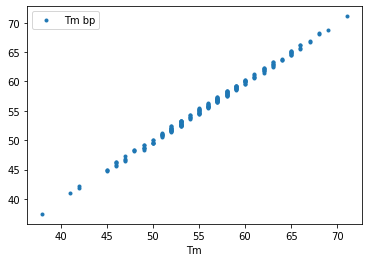

In [78]:
NEB.plot(x='Tm', y='Tm bp', style='.')

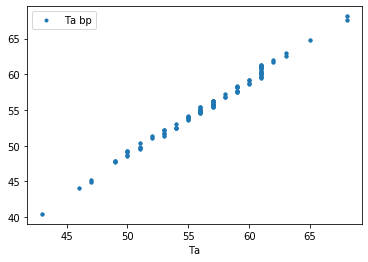

In [79]:
NEB.plot(x='Ta', y='Ta bp', style='.')